- Cuántos Exposed dado el crecimiento de confirmados en México? 
- Cómo conseguimos Hospitalized(t)?

In [1]:
# Script with all the relevant functions and eqs. of motion
%run 'corona.py'

## Parameter Estimation
These numbers are based in the quantities reported in [Alex Arenas et al. model]() as follows:
- $\lambda = \langle k^g \rangle \ln (1 - \beta)$ 
- $\kappa = \eta^{-1} + \alpha^{-1} = 1/5.2$
- $\gamma_I = \mu^g(1 - \gamma^g) = 0.297$
- $\mu_I = 0$
- $\alpha = \mu^g \gamma^g = 0.0156$ 
- $\mu_H = \omega^g\psi^g = 0.06$ 
- $\gamma_H = (1 - \omega^g)\chi^g = 0.058$ 

For $\lambda$, we solve $R_0 = \frac{\lambda}{\gamma_I + \mu_I + \alpha} $, where we take $R_0 = 2.3 \pm 0.3$ as, according to the [CMMID](https://cmmid.github.io/topics/covid19/current-patterns-transmission/global-time-varying-transmission.html),
- $R_0 \approx 2.2 \pm 0.2$ at 01/feb/20 in China
- $R_0 \approx 2.2 \pm 0.3$ at 01/feb/20 in Italy
- $R_0$ unknown at 01/feb/20 in the UK

Note that $R_0$ is the in-flow of infection ($S \to I$) over its out-flow ($I \to \{R,D\}$). Note that $R$ and $D$ are the only absorbing nodes in the SEIHRD chain, thus $R+D$ represents the total out-flow of infection. No individual die for natural causes in the time scale that we are working with. Thus, the total population is conserved throughout the dynamics (including the deseaded by the virus), and hence, the time scales are irrelevant. 

In [5]:
R_0 = 2.3

# Arenas params
β = 0.06 # infectivity of the desease (per contact per day)
k_avg = 13.3 # average contacts per day. (11.8, 13.3, 6.6) in the report
μg = 1/3.2 # escape (from Infected) rate. (1/1, 1/3.2, 1/3.2) in the report
γg = 0.05 # fraction of cases requiring ICU. (0.002, 0.05, 0.36) in the report
# γg should be a weighted sum of %_young * 0.002 + %_mid * 0.05 + %_old * 0.36
ωg = 0.42 # fatality rate of ICU patients
ψg = 1/7  # death rate
χg = 1/10 # ICU discharge rate

# SEIHRD params
κ = 1/5.2 # η^-1 + α^-1
γI = μg*(1 - γg)
μI = 0
α = μg*γg
μH = ωg*ψg
γH = (1 - ωg)*χg
λ = -k_avg * np.log( 1 - β ) # linearization of P(t)
# λ = R_0 * (γI + μI + α)  # using the reproduction number

# λ / (γI + μI + α) ->  R_0

params = (λ, κ, γI, μI, α, γH, μH)
params

(0.8229428694505642,
 0.1923076923076923,
 0.296875,
 0,
 0.015625,
 0.05800000000000001,
 0.06)

## Initial conditions estimation 

### Spain 

In [6]:
N_esp = 46_660_000
initial_date = '3/12/20'


confirmed = country_to_timeseries(global_confirmed, 'Spain').loc[initial_date, 'Spain']
deaths = country_to_timeseries(global_deaths, 'Spain').loc[initial_date, 'Spain']
recovered = country_to_timeseries(global_recovered, 'Spain').loc[initial_date, 'Spain']

r = 4
R0 = recovered / N_esp
D0 = deaths / N_esp
I0 = (confirmed/N_esp) - R0 - D0  # confirmed cases
E0 = r*I0 # cases without symptoms, which are not yet detected
H0 = 0 # no hospitalization data yet
S0 = (1 - E0 - I0 - R0 - D0 - H0)

x0 = [S0, E0, I0, H0, R0, D0] 

x0

[0.9997764037719674,
 0.00017479639948564081,
 4.3699099871410203e-05,
 0,
 3.921988855550793e-06,
 1.178739819974282e-06]

In [13]:
### Solving the system ###
prediction_horizon = -1 # days
n_days = (datetime.datetime.today() - datetime.datetime.strptime(initial_date, '%m/%d/%y')).days + prediction_horizon

sol_markov = solve(SEIHRD_markov_step, x0, 0.0, n_days, *params)

MAE: 996.9469450883507


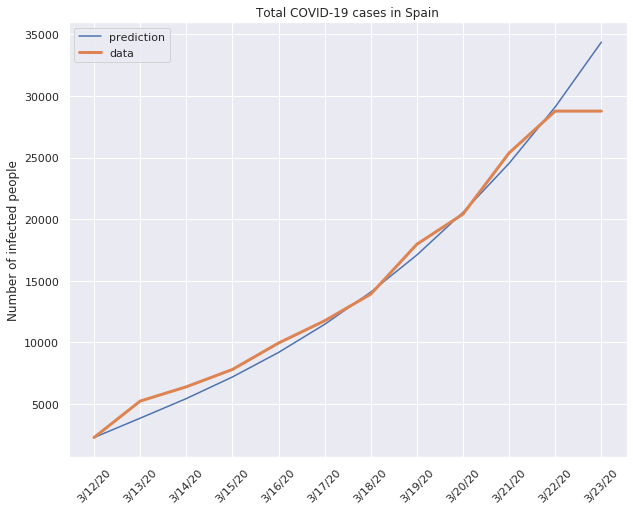

In [14]:
sol_markov = solve(SEIHRD_markov_step, x0, 0, n_days, *params)

plt.figure( figsize=(10,8) )

prediction = (total_cases_timeseries(sol_markov, N=N_esp))
data = country_to_timeseries(global_confirmed, 'Spain').loc[initial_date:, 'Spain']

plt.plot( (prediction), label='prediction')
plt.plot( (data), lw=3, label='data')
plt.xticks(rotation=45)
plt.ylabel('Number of infected people')
plt.legend()
# plt.yscale('log')
plt.title('Total COVID-19 cases in Spain')

print('MAE: {}'.format(MAE(prediction,data.values)))

MAE: 6651.341920572253


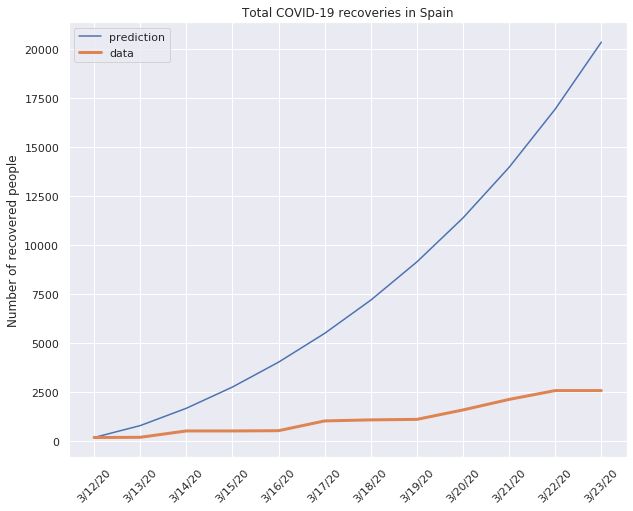

In [15]:
plt.figure( figsize=(10,8) )

prediction = sol_markov[:,4]*N_esp
data = country_to_timeseries(global_recovered, 'Spain').loc[initial_date:, 'Spain']

plt.plot( (prediction), label='prediction')
plt.plot( (data), lw=3, label='data')
plt.xticks(rotation=45)
plt.ylabel('Number of recovered people')
plt.legend()
# plt.yscale('log')
plt.title('Total COVID-19 recoveries in Spain')

print('MAE: {}'.format(MAE(prediction,data.values)))

MAE: 639.7608805279576


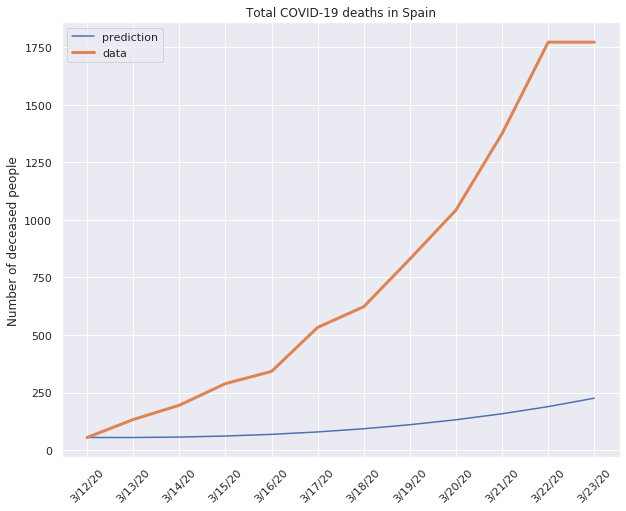

In [16]:
plt.figure( figsize=(10,8) )

prediction = sol_markov[:,5]*N_esp
data = country_to_timeseries(global_deaths, 'Spain').loc[initial_date:, 'Spain']

plt.plot( (prediction), label='prediction')
plt.plot( (data), lw=3, label='data')
plt.xticks(rotation=45)
plt.ylabel('Number of deceased people')
plt.legend()
# plt.yscale('log')
plt.title('Total COVID-19 deaths in Spain')

print('MAE: {}'.format(MAE(prediction,data.values)))

In [17]:
### Spain csv ### 
sol_to_csv(sol_markov, initial_date, N_esp)

,Totales,Recuperados,Muertes,Hospitalizados
2020-03-12,2277.000000,183.000000,55.000000,0.000000
2020-03-13,3845.461538,788.328125,55.000000,31.859375
2020-03-14,5434.912266,1671.976074,56.911563,74.510501
2020-03-15,7188.647739,2754.403440,61.382193,122.460670
2020-03-16,9179.664172,4023.344085,68.729833,174.422833
2020-03-17,11460.201009,5492.057188,79.195203,230.609180
2020-03-18,14079.371732,7185.252041,93.031754,291.808850
2020-03-19,17089.853318,9134.619183,110.540285,359.082892
2020-03-20,20550.886760,11377.736744,132.085258,433.673782
2020-03-21,24530.105658,13958.209020,158.105685,516.990759


### Mexico 

In [18]:
N_mex = 128_569_304 # https://www.worldometers.info/world-population/mexico-population/ (2020-03-34)
initial_date = '2020-03-12' # This is the date in which the trend becomes exponential

confirmed = national_timeseries(mex_confirmed).loc[initial_date,'Mexico_pais']
deaths = national_timeseries(mex_deaths).loc[initial_date,'Mexico_pais']
recovered = national_timeseries(mex_recovered).loc[initial_date,'Mexico_pais']

# setting initial conditions
r = 6
R0 = recovered / N_mex
D0 = deaths / N_mex
I0 = (confirmed/N_mex) - R0 - D0  # confirmed cases
E0 = r*I0 # cases without symptoms, which are not yet detected
H0 = 0 # no hospitalization data yet
S0 = (1 - E0 - I0 - R0 - D0 - H0)

x0 = [S0, E0, I0, H0, R0, D0] 

x0

[0.9999991755419319,
 7.000115673022543e-07,
 1.1666859455037572e-07,
 0,
 7.777906303358382e-09,
 0.0]

In [20]:
### Solving the system ###
prediction_horizon = -1 # days
n_days = (datetime.datetime.today() - datetime.datetime.strptime(initial_date, '%Y-%m-%d')).days + prediction_horizon

sol_markov = solve(SEIHRD_markov_step, x0, 0.0, n_days, *params)

MAE: 118.05991961299482


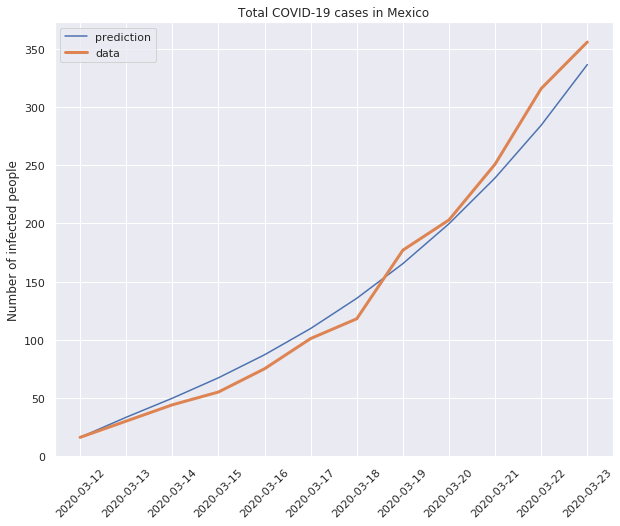

In [21]:
plt.figure( figsize=(10,8) )

prediction = (total_cases_timeseries(sol_markov, N=N_mex))
data = national_timeseries(mex_confirmed, log=False).loc[initial_date:]


plt.plot( (prediction), label='prediction')
plt.plot( (data), lw=3, label='data')
plt.xticks(rotation=45)
plt.ylabel('Number of infected people')
plt.legend()
# plt.yscale('log')
plt.title('Total COVID-19 cases in Mexico')

print('MAE: {}'.format( MAE(prediction,data.values) ) )

MAE: 72.238183761553


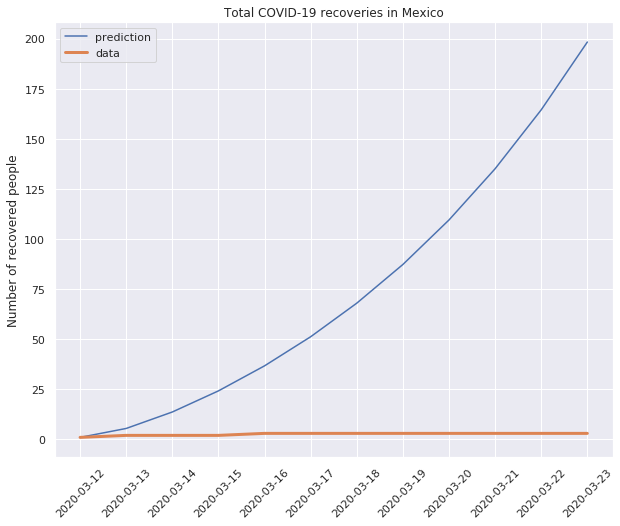

In [22]:
plt.figure( figsize=(10,8) )

prediction = sol_markov[:,4]*N_mex
data = national_timeseries(mex_recovered, log=False).loc[initial_date:]

plt.plot( (prediction), label='prediction')
plt.plot( (data), lw=3, label='data')
plt.xticks(rotation=45)
plt.ylabel('Number of recovered people')
plt.legend()
# plt.yscale('log')
plt.title('Total COVID-19 recoveries in Mexico')

print('MAE: {}'.format(MAE(prediction,data.values)))

MAE: 1.0118448768546722


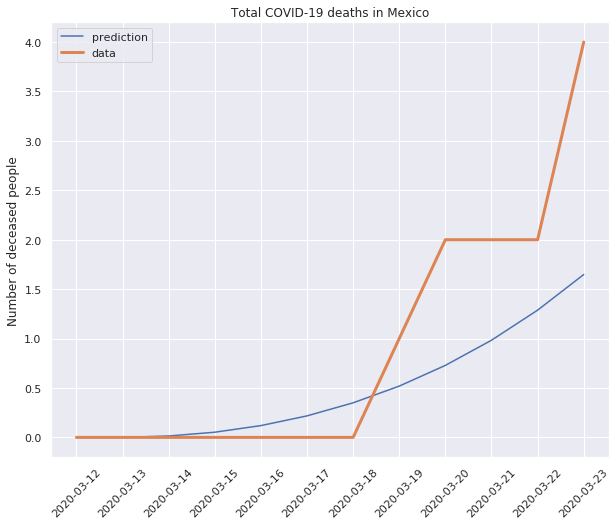

In [23]:
plt.figure( figsize=(10,8) )

prediction = sol_markov[:,5]*N_mex
data = national_timeseries(mex_deaths, log=False).loc[initial_date:]

plt.plot( (prediction), label='prediction')
plt.plot( (data), lw=3, label='data')
plt.xticks(rotation=45)
plt.ylabel('Number of deceased people')
plt.legend()
# plt.yscale('log')
plt.title('Total COVID-19 deaths in Mexico')

print('MAE: {}'.format(MAE(prediction,data.values)))

In [24]:
### Mexico csv ### 
sol_to_csv(sol_markov, initial_date, N_mex)

,Totales,Recuperados,Muertes,Hospitalizados
2020-03-12,16.000000,1.000000,0.000000,0.000000
2020-03-13,33.307692,5.453125,0.000000,0.234375
2020-03-14,49.660854,13.666463,0.014062,0.638284
2020-03-15,67.240296,24.195653,0.052360,1.115186
2020-03-16,87.032240,36.692597,0.119271,1.637924
2020-03-17,109.645427,51.210511,0.217546,2.203750
2020-03-18,135.598486,67.967372,0.349771,2.818920
2020-03-19,165.425172,87.268151,0.518906,3.493513
2020-03-20,199.717644,109.482454,0.728517,4.239788
2020-03-21,239.149373,135.041968,0.982904,5.071788
